<a href="https://colab.research.google.com/github/MaggieLieu/MLiS_examples/blob/master/Graph_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
%matplotlib inline
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


# Graph CNN

A simple adjacency matrix


In [0]:
A = np.matrix([
    [0, 1, 0, 0],
    [0, 0, 1, 1], 
    [0, 1, 0, 0],
    [1, 0, 1, 0]],
    dtype=float
)

Make 2 features for each node

In [6]:
X = np.matrix([
            [i, -i]
            for i in range(A.shape[0])
        ], dtype=float)
X

matrix([[ 0.,  0.],
        [ 1., -1.],
        [ 2., -2.],
        [ 3., -3.]])

Propogate

In [7]:
A * X

matrix([[ 1., -1.],
        [ 5., -5.],
        [ 1., -1.],
        [ 2., -2.]])

Add self-loops

In [8]:
I = np.matrix(np.eye(A.shape[0]))
A_hat = A + I
A_hat * X

matrix([[ 1., -1.],
        [ 6., -6.],
        [ 3., -3.],
        [ 5., -5.]])

Let's consider the Zachary karate club data set. Here two karate teachers had a conflict and tried recruiting members in each others group. Two groups will be formed at the end, but can we predict what those groups will be?

In [0]:
import networkx as nx

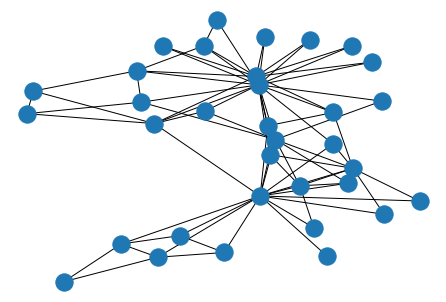

In [14]:
G = nx.karate_club_graph() # import zachary karate club data
nx.draw(G) #plot spatial network

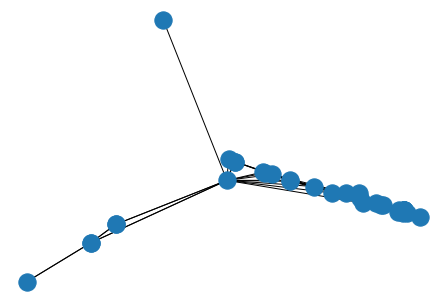

In [15]:
nx.draw_spectral(G) #plot spectral network